# 1. Plot initial generator outputs

In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from ipywidgets import interact, IntSlider, Dropdown

from lpbf.schemas.state import ThermalStates
from lpbf.utils.io import load_state

states: ThermalStates = load_state("../artifacts/runs/run_0001/states.pt", ThermalStates, map_location="cpu")
snap = states.snapshots

print("Meta:", states.meta)
print("Snapshots keys:", [k for k in ["T","E_acc","t_since"]])
print("T shape:", snap.T.shape, "t shape:", snap.t.shape)


In [ ]:
def show_frame(field: str, i: int, vmin=None, vmax=None):
    arr = getattr(snap, field)[i, 0].numpy()  # [H,W]
    t = float(snap.t[i].item())
    ev = int(snap.event_idx[i].item())

    plt.figure(figsize=(5,4))
    plt.imshow(arr, origin="lower", vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(f"{field} | frame={i} | t={t:.3f} | event={ev}")
    plt.tight_layout()
    plt.show()


In [ ]:
# Precompute stable vmin/vmax for nicer visualization (optional)
T_all = snap.T[:,0].numpy()
T_vmin, T_vmax = float(T_all.min()), float(T_all.max())

E_all = snap.E_acc[:,0].numpy()
E_vmin, E_vmax = float(E_all.min()), float(E_all.max())

S_all = snap.t_since[:,0].numpy()
S_vmin, S_vmax = float(S_all.min()), float(S_all.max())

ranges = {
    "T": (T_vmin, T_vmax),
    "E_acc": (E_vmin, E_vmax),
    "t_since": (S_vmin, S_vmax),
}

def view(i=0, field="T"):
    vmin, vmax = ranges[field]
    show_frame(field, i, vmin=vmin, vmax=vmax)

interact(
    view,
    i=IntSlider(min=0, max=snap.T.shape[0]-1, step=1, value=0),
    field=Dropdown(options=["T","E_acc","t_since"], value="T"),
)


interactive(children=(IntSlider(value=0, description='i', max=20), Dropdown(description='field', options=('T',…

<function __main__.view(i=0, field='T')>

In [ ]:
field = "T"  # change to "E_acc" or "t_since"

data = getattr(snap, field)[:,0].numpy()  # [N,H,W]
times = snap.t.numpy()
events = snap.event_idx.numpy()

vmin, vmax = float(data.min()), float(data.max())

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(data[0], origin="lower", vmin=vmin, vmax=vmax)
cb = plt.colorbar(im, ax=ax)
title = ax.set_title(f"{field} | frame=0")

def update(frame):
    im.set_array(data[frame])
    title.set_text(f"{field} | frame={frame} | t={times[frame]:.3f} | event={events[frame]}")
    return (im, title)

ani = animation.FuncAnimation(fig, update, frames=data.shape[0], interval=200, blit=False)
plt.close(fig)
ani


In [ ]:
field = "T"
data = getattr(snap, field)[:,0].numpy()
times = snap.t.numpy()
events = snap.event_idx.numpy()
vmin, vmax = float(data.min()), float(data.max())

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(data[0], origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax)
title = ax.set_title("")

def update(frame):
    im.set_array(data[frame])
    title.set_text(f"{field} | frame={frame} | t={times[frame]:.3f} | event={events[frame]}")
    return (im, title)

ani = animation.FuncAnimation(fig, update, frames=data.shape[0], interval=150, blit=False)
ani.save("../artifacts/runs/run_0001/animation_T.gif", writer="pillow", dpi=120)
plt.close(fig)

print("Saved: ../artifacts/animation_T.gif")


Saved: ../artifacts/animation_T.gif


# 02. With cooling Rate

In [ ]:
states: ThermalStates = load_state("../artifacts/runs/run_0002/states.pt", ThermalStates, map_location="cpu")
snap = states.snapshots

print("Meta:", states.meta)
print("Snapshots keys:", [k for k in ["T","E_acc","t_since"]])
print("T shape:", snap.T.shape, "t shape:", snap.t.shape)

Meta: H=128 W=128 dt=0.0006 loss_h=0.2 T_ambient=0.05 description='Time-resolved LPBF dot-by-dot simulation with online cooling-rate tracking' cooling_delta_t=0.04 cooling_delta_t_eff=0.0402 cooling_delta_steps=67
Snapshots keys: ['T', 'E_acc', 't_since']
T shape: torch.Size([21, 1, 128, 128]) t shape: torch.Size([21])


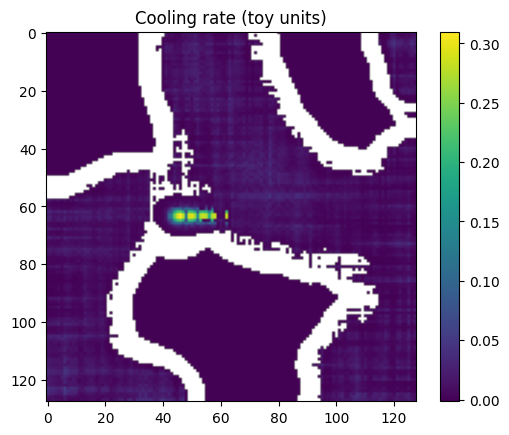

In [ ]:
snap = states.snapshots
plt.imshow(snap.cooling_rate[-1,0])
plt.title("Cooling rate (toy units)")
plt.colorbar()


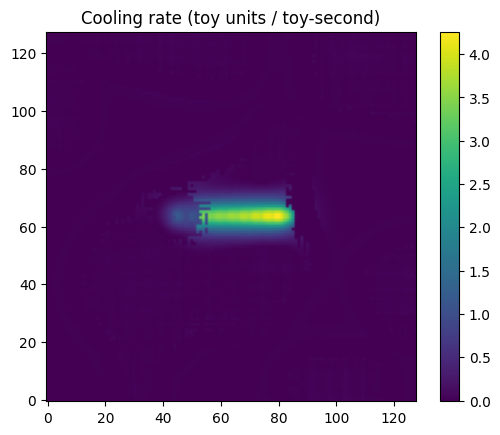

Δt_eff: 0.0402


In [ ]:
import matplotlib.pyplot as plt

cr = states.final.cooling_rate[0,0].numpy()
plt.figure()
plt.imshow(cr, origin="lower")
plt.colorbar()
plt.title("Cooling rate (toy units / toy-second)")
plt.show()

print("Δt_eff:", states.meta.cooling_delta_t_eff)

In [ ]:
# Precompute stable vmin/vmax for nicer visualization (optional)
T_all = snap.T[:,0].numpy()
T_vmin, T_vmax = float(T_all.min()), float(T_all.max())

E_all = snap.E_acc[:,0].numpy()
E_vmin, E_vmax = float(E_all.min()), float(E_all.max())

S_all = snap.t_since[:,0].numpy()
S_vmin, S_vmax = float(S_all.min()), float(S_all.max())

R_all = snap.cooling_rate[:, 0].numpy()
R_min, R_max = float(R_all.min()), float(R_all.max())

ranges = {
    "T": (T_vmin, T_vmax),
    "E_acc": (E_vmin, E_vmax),
    "t_since": (S_vmin, S_vmax),
    "cooling_rate": (R_min, R_max),
}

def view(i=0, field="T"):
    vmin, vmax = ranges[field]
    show_frame(field, i, vmin=vmin, vmax=vmax)

interact(
    view,
    i=IntSlider(min=0, max=snap.T.shape[0]-1, step=1, value=0),
    field=Dropdown(options=["T","E_acc","t_since", "cooling_rate"], value="T"),
);

interactive(children=(IntSlider(value=0, description='i', max=20), Dropdown(description='field', options=('T',…

nan count: 0


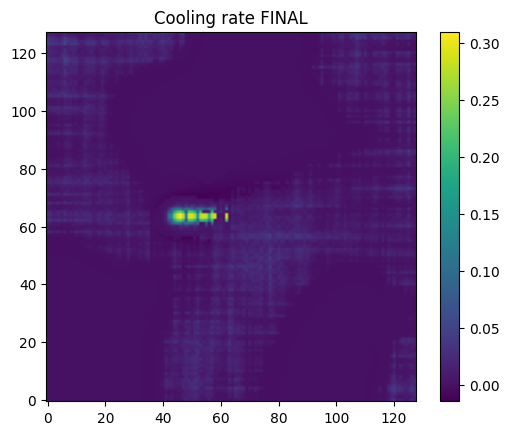

In [ ]:
cr = states.final.cooling_rate[0,0].numpy()
import numpy as np, matplotlib.pyplot as plt
print("nan count:", np.isnan(cr).sum())
plt.imshow(cr, origin="lower"); plt.colorbar(); plt.title("Cooling rate FINAL"); plt.show()


In [ ]:
field = "T"  # change to "E_acc" or "t_since"

data = getattr(snap, field)[:,0].numpy()  # [N,H,W]
times = snap.t.numpy()
events = snap.event_idx.numpy()

vmin, vmax = float(data.min()), float(data.max())

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(data[0], origin="lower", vmin=vmin, vmax=vmax)
cb = plt.colorbar(im, ax=ax)
title = ax.set_title(f"{field} | frame=0")

def update(frame):
    im.set_array(data[frame])
    title.set_text(f"{field} | frame={frame} | t={times[frame]:.3f} | event={events[frame]}")
    return (im, title)

ani = animation.FuncAnimation(fig, update, frames=data.shape[0], interval=200, blit=False)
plt.close(fig)
ani

In [ ]:
# requires imagemagick OR pillow writer
# easiest: pillow
from matplotlib import animation

field = "T"
data = getattr(snap, field)[:,0].numpy()
times = snap.t.numpy()
events = snap.event_idx.numpy()
vmin, vmax = float(data.min()), float(data.max())

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(data[0], origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax)
title = ax.set_title("")

def update(frame):
    im.set_array(data[frame])
    title.set_text(f"{field} | frame={frame} | t={times[frame]:.3f} | event={events[frame]}")
    return (im, title)

ani = animation.FuncAnimation(fig, update, frames=data.shape[0], interval=150, blit=False)
ani.save("../artifacts/runs/run_0002/animation_R.gif", writer="pillow", dpi=120)
plt.close(fig)

print("Saved: ../artifacts/animation_T.gif")


Saved: ../artifacts/animation_T.gif
